## Superalloy 4D-STEM data analysis
2022SP_MAT_SCI_466-0_SEC1 Analytical Electron Microscopy:  Analytical Electron Microscopy at Northwestern University 

Instructors: Vinayak P. Dravid, Roberto dos Reis

TAs: Matthew Cheng, Stephanie Ribet

Data available through [Zenodo](https://zenodo.org/record/4307783#.YmKwA9rMJD8).

More information available from the [VPD Group](https://vpd.ms.northwestern.edu/) and [NU*ANCE* Center](http://www.nuance.northwestern.edu/)

### 1.  Load packages and data

In [1]:
#import necessary packages
%matplotlib nbagg

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

from scipy import ndimage
from scipy.spatial import distance

import math

from skimage import filters
from skimage.morphology import disk
from skimage import feature

from ncempy.io import dm

In [3]:
#load file using ncem's DM reader, many other packages available for loading data

filename='4D_data.dm4'
im0 = dm.dmReader (filename)
data = im0['data'][:]
print(data.shape)

(213, 342, 128, 128)


In [4]:
#simplest image and average diffraction pattern
#real space: axes=0,1
#diffraction space: axes = 2,3

aveimage = np.average(data, axis=(2,3)) #an average of diffraciton space
aveDP = np.average(data, axis=(0,1))  #an average of real space 

<IPython.core.display.Javascript object>


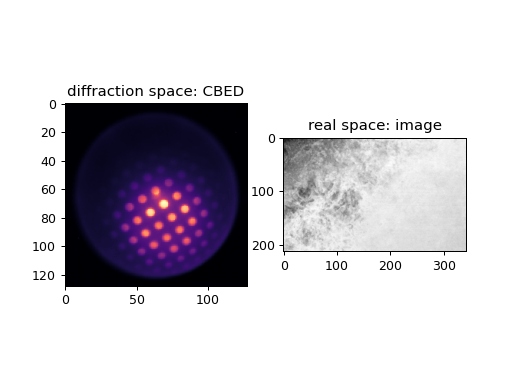

In [5]:
#plot virtual image and diffraction pattern

fig, ax = plt.subplots(ncols=2) #create figure with two subplots
ax[0].imshow(aveDP, cmap='magma') #plot diffraction pattern 
ax[1].imshow(aveimage, cmap='gray') #plot image

ax[0].set_title('diffraction space: CBED')
ax[1].set_title('real space: image')

plt.show()

### 2.  Reduce data size
- Binning data 
    - already done for this data set
    - appropriate degree of binning depends on dataset/reconstruction method
- Cropping 

In [6]:
data=data[:,:,27:127,20:120] #crop empty areas of diffraction space to save computational time

<IPython.core.display.Javascript object>


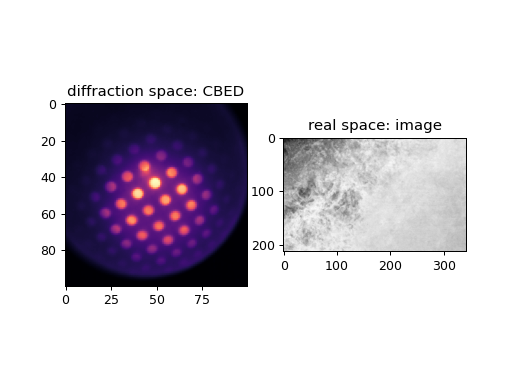

In [7]:
#check cropping by plotting average CBED pattern and image after cropping

aveimage = np.average(data, axis=(2,3))
aveDP = np.average(data, axis=(0,1))

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(aveDP, cmap='magma')
ax[1].imshow(aveimage, cmap='gray')

ax[0].set_title('diffraction space: CBED')
ax[1].set_title('real space: image')

plt.show()

### 3. Create virtual reconstructions
- Virtual BF, DF, ABF images can be reconstructed from scanning diffraction datasets.
- Detectors can be tailored to diffraction pattern to highlight specific phases. 
- Steps:
    1. Find center of diffraction pattern
    2. Create binary mask for diffraction space filtering 
    3. Integrate

<IPython.core.display.Javascript object>


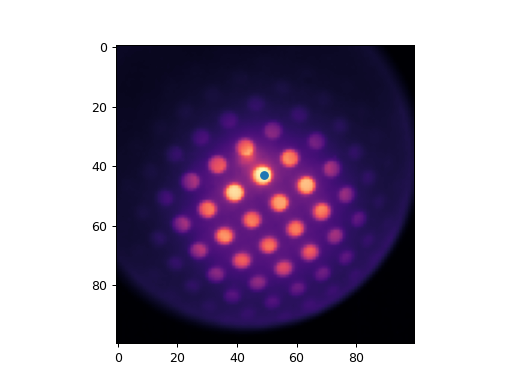

ic is [43.]
jc is [49.]


In [8]:
#find center of DP using blob tool - we want our virtual detectors to be centered on our bright field disk.

blob=feature.blob_log(aveDP, min_sigma=3, max_sigma=6, threshold=69) #use scikit tool

fig, ax = plt.subplots()
ax.imshow(aveDP, cmap='magma')
ax.scatter(blob[:,1], blob[:,0])
plt.show()

ic=blob[:,0]
jc=blob[:,1]

print("ic is " + str(ic))
print("jc is " + str(jc))

<IPython.core.display.Javascript object>


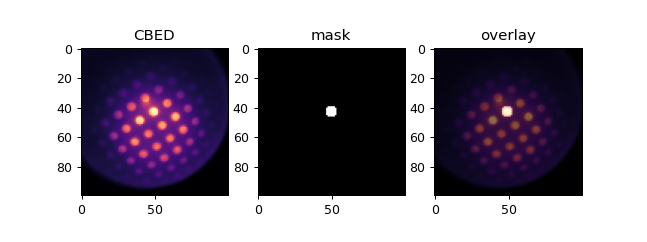

In [9]:
#create BF image

#create mask using a logical (true/false) statement
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_BF = (x - ic) ** 2 + (y-jc) ** 2 < 4 ** 2

#plot mask to check alignment 
fig, ax = plt.subplots(ncols=3, figsize=(8,3))
ax[0].imshow(aveDP, cmap='magma')
ax[1].imshow(mask_BF, cmap='gray')

ax[2].imshow(aveDP, cmap='magma')
ax[2].imshow(mask_BF, cmap='gray', alpha=0.5)

ax[0].set_title('CBED')
ax[1].set_title('mask')
ax[2].set_title('overlay')
plt.show()


In [10]:
#initalize BF image by creating an empty array (an array filled with zeros)
BF=np.zeros((aveimage.shape[0],aveimage.shape[1]))

#integrate diffraction space to create BF image
for i in range(0,int(aveDP.shape[0])):
    for j in range(0,int(aveDP.shape[1])):
        if mask_BF[i,j]:
            BF=BF+data[:,:,i,j]

<IPython.core.display.Javascript object>


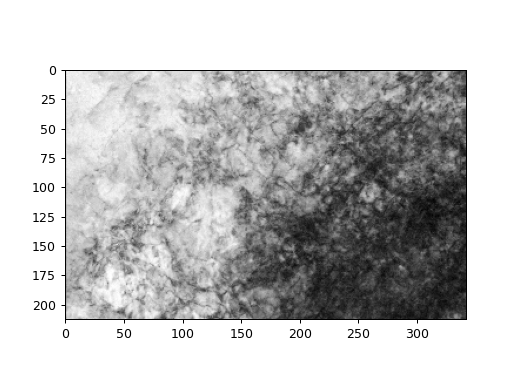

In [11]:
#plot BF image 
fig,ax=plt.subplots()
ax.imshow(BF, cmap=plt.cm.gray)
plt.show()

<IPython.core.display.Javascript object>


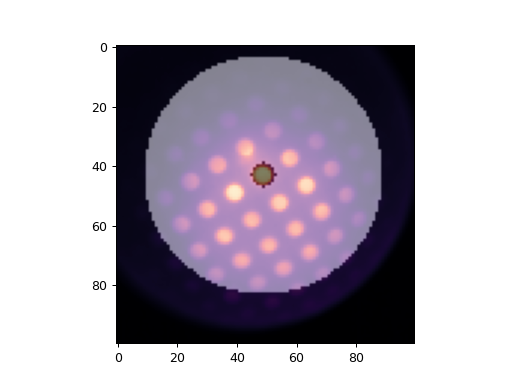

In [12]:
#create DF image

#create DF mask
mask1 = (x - ic) ** 2 + (y-jc) ** 2 > 4 ** 2 #inner diameter 
mask2 = (x - ic) ** 2 + (y-jc) ** 2 < 40 ** 2 #outer diameter 
mask_DF=np.logical_and(mask1, mask2) #use logical to create annular detector
#note: inner and outer diameters can be modified

#check mask
fig, ax = plt.subplots()
ax.imshow(aveDP, cmap='magma')
ax.imshow(mask_DF, cmap='gray', alpha=0.5)
plt.show()

#initialize DF image
DF=np.zeros((aveimage.shape[0],aveimage.shape[1]))

#integrate to create DF image
for i in range(0,int(aveDP.shape[0])):
    for j in range(0,int(aveDP.shape[1])):
        if mask_DF[i,j]:
            DF=DF+data[:,:,i,j]

<IPython.core.display.Javascript object>


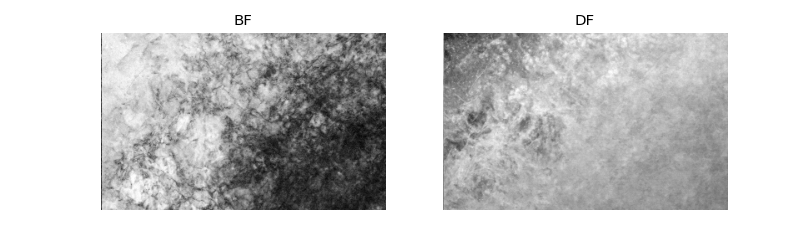

In [13]:
#compare BF and DF
fig,ax=plt.subplots(ncols=2, figsize=(10,3))
ax[0].imshow(BF, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('BF')


ax[1].imshow(DF, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('DF')

plt.show()

<IPython.core.display.Javascript object>


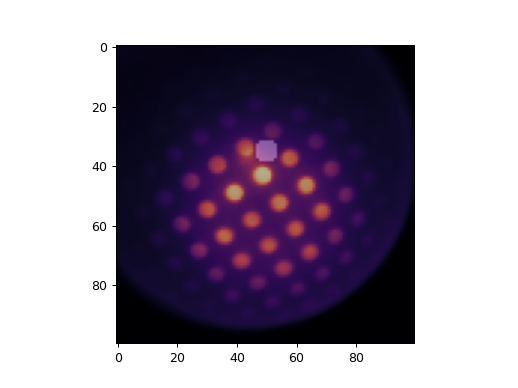

In [14]:
#check precipitate

x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_ppt = (x - 35) ** 2 + (y-50) ** 2 < 4 ** 2

ppt=np.zeros((aveimage.shape[0],aveimage.shape[1]))

for i in range(0,int(aveDP.shape[0])):
    for j in range(0,int(aveDP.shape[1])):
        if mask_ppt[i,j]:
            ppt=ppt+data[:,:,i,j]
            
fig, ax = plt.subplots()
ax.imshow(aveDP, cmap='magma')
ax.imshow(mask_ppt, cmap='gray', alpha=0.3)
plt.show()

<IPython.core.display.Javascript object>


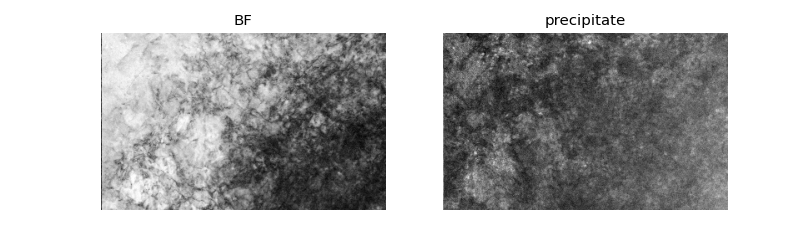

In [15]:
#compare conventional BF and precipitate

fig,ax=plt.subplots(ncols=2, figsize=(10,3))
ax[0].imshow(BF, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('BF')

ax[1].imshow(ppt, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('precipitate')

plt.show()

<IPython.core.display.Javascript object>


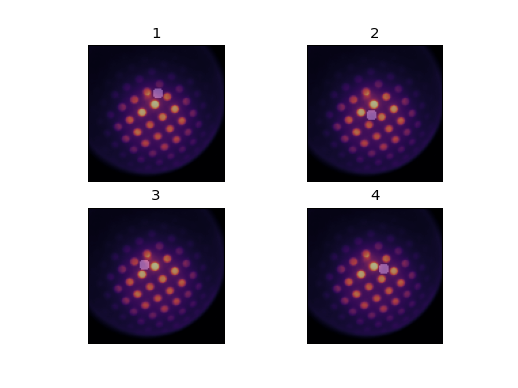

In [16]:
#check 4 ppt reflections

x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_ppt1 = (x - 35) ** 2 + (y-51) ** 2 < 4 ** 2
mask_ppt2 = (x - 51) ** 2 + (y-47) ** 2 < 4 ** 2
mask_ppt3 = (x - 42) ** 2 + (y-41) ** 2 < 4 ** 2
mask_ppt4 = (x - 45) ** 2 + (y-56) ** 2 < 4 ** 2

ppt1=np.zeros((aveimage.shape[0],aveimage.shape[1]))
ppt2=np.zeros((aveimage.shape[0],aveimage.shape[1]))
ppt3=np.zeros((aveimage.shape[0],aveimage.shape[1]))
ppt4=np.zeros((aveimage.shape[0],aveimage.shape[1]))

for i in range(0,int(aveDP.shape[0])):
    for j in range(0,int(aveDP.shape[1])):
        if mask_ppt1[i,j]:
            ppt1=ppt1+data[:,:,i,j]
        if mask_ppt2[i,j]:
            ppt2=ppt2+data[:,:,i,j]
        if mask_ppt3[i,j]:
            ppt3=ppt3+data[:,:,i,j]
        if mask_ppt4[i,j]:
            ppt4=ppt4+data[:,:,i,j]
            
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].imshow(aveDP, cmap='magma')
ax[0,0].imshow(mask_ppt1, cmap='gray', alpha=0.3)
ax[0,0].set_title('1')

ax[0,1].imshow(aveDP, cmap='magma')
ax[0,1].imshow(mask_ppt2, cmap='gray', alpha=0.3)
ax[0,1].set_title('2')

ax[1,0].imshow(aveDP, cmap='magma')
ax[1,0].imshow(mask_ppt3, cmap='gray', alpha=0.3)
ax[1,0].set_title('3')

ax[1,1].imshow(aveDP, cmap='magma')
ax[1,1].imshow(mask_ppt4, cmap='gray', alpha=0.3)
ax[1,1].set_title('4')

for axss in ax.flatten():
    axss.set_yticks([])
    axss.set_xticks([])

plt.show()

<IPython.core.display.Javascript object>


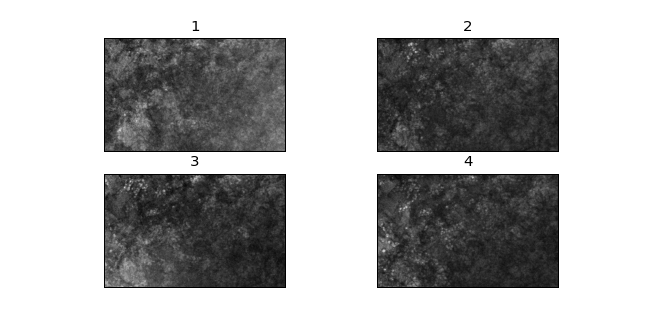

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,4))
ax[0,0].imshow(ppt1, cmap='gray')
ax[0,0].set_title('1')

ax[0,1].imshow(ppt2, cmap='gray')
ax[0,1].set_title('2')

ax[1,0].imshow(ppt3, cmap='gray')
ax[1,0].set_title('3')

ax[1,1].imshow(ppt4, cmap='gray')
ax[1,1].set_title('4')

for axss in ax.flatten():
    axss.set_yticks([])
    axss.set_xticks([])

plt.show()

<IPython.core.display.Javascript object>


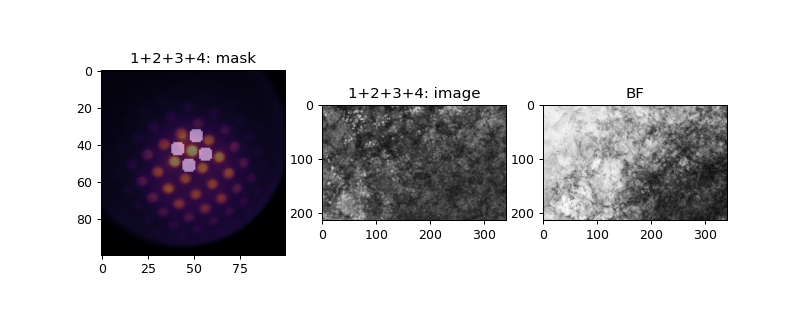

In [18]:
fig, ax = plt.subplots(ncols=3, figsize=(10,4))
pptsum=ppt1+ppt2+ppt3+ppt4
sum_mask=mask_ppt1+mask_ppt2+mask_ppt3+mask_ppt4


ax[0].imshow(aveDP, cmap='magma')
ax[0].imshow(sum_mask, cmap='gray', alpha=0.5)
ax[0].set_title('1+2+3+4: mask')

ax[1].imshow(pptsum, cmap='gray')
ax[1].set_title('1+2+3+4: image')

ax[2].imshow(BF, cmap='gray')
ax[2].set_title('BF')

plt.show()

<IPython.core.display.Javascript object>


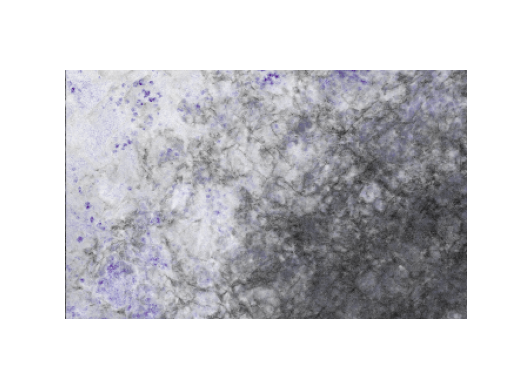

In [19]:
#colormaps: https://matplotlib.org/3.3.3/tutorials/colors/colormaps.html
#make your own color map introducing transparency            
cmap = plt.cm.Purples
my_purple = cmap(np.arange(cmap.N))
my_purple[:,-1] = np.linspace(0, 1, cmap.N)
my_purple = ListedColormap(my_purple)

#plot precipitate on top of matrix using new colormap 
fig,ax = plt.subplots()
ax.imshow(BF, cmap = "gray")
ax.imshow(pptsum, cmap = my_purple)

ax.axis('off')

plt.show()